# Filter Visualization (Weight decay 0.1)

Here we visualize filters and outputs using the autoencoder network architecture implemented in Caffe.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and make sure you have the pretrained autoencoder model. In this example we test on UCSD anomaly detection dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/opt/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

MODEL_FILE = '/home/ucsd_autoencoder_deploy.prototxt'
PRETRAINED = '/home/ucsd_autoencoder_nesterov_weight_decay_iter_80000.caffemodel'
IMAGE_FILE = '/home/test_spatial/60_40/slice02/1_02_001.jpg'

Set Caffe to GPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [2]:
caffe.set_mode_gpu()
# caffe.TEST means that we load the net in the test phase
# To load the net in the train phase simply change it to caffe.TRAIN
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# transformer.set_transpose('data', (2,0,1))
# Uncomment below when the mean image is available in .npy format
# transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Calculate the reconstruction error of the image by reshaping the net for the single input then doing the forward pass.

In [3]:
net.blobs['data'].reshape(1,3,20,30)
input_image = caffe.io.load_image(IMAGE_FILE)
input_image1 = np.copy(input_image)

# net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
caffe_input = np.zeros((1,3,20,30))
# Swap axes from (20,30,3) to (3,20,30)
# Now is (20,30,3), swap to (3,30,20)
temp = np.swapaxes(input_image,0,2)
# Now is (3,30,20), we want (3,20,30)
input_image = np.swapaxes(temp,1,2)
caffe_input[0,:,:,:] = input_image[:,:,:]

net.blobs['data'].data[...] = caffe_input
out = net.forward()
print("The cross entropy loss is {}.".format(out['cross_entropy_loss']))
print("The L2 error is {}.".format(out['l2_error']))

The cross entropy loss is [[[[ 1240.35205078]]]].
The L2 error is [[[[ 42.07661819]]]].


The layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [4]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 20, 30)),
 ('data_input_0_split_0', (1, 3, 20, 30)),
 ('data_input_0_split_1', (1, 3, 20, 30)),
 ('flatdata', (1, 1800, 1, 1)),
 ('flatdata_flatdata_0_split_0', (1, 1800, 1, 1)),
 ('flatdata_flatdata_0_split_1', (1, 1800, 1, 1)),
 ('encode1', (1, 2400, 1, 1)),
 ('encode1neuron', (1, 2400, 1, 1)),
 ('encode2', (1, 1200, 1, 1)),
 ('encode2neuron', (1, 1200, 1, 1)),
 ('encode3', (1, 600, 1, 1)),
 ('encode3neuron', (1, 600, 1, 1)),
 ('encode4', (1, 72, 1, 1)),
 ('decode4', (1, 600, 1, 1)),
 ('decode4neuron', (1, 600, 1, 1)),
 ('decode3', (1, 1200, 1, 1)),
 ('decode3neuron', (1, 1200, 1, 1)),
 ('decode2', (1, 2400, 1, 1)),
 ('decode2neuron', (1, 2400, 1, 1)),
 ('decode1', (1, 1800, 1, 1)),
 ('decode1_decode1_0_split_0', (1, 1800, 1, 1)),
 ('decode1_decode1_0_split_1', (1, 1800, 1, 1)),
 ('cross_entropy_loss', (1, 1, 1, 1)),
 ('decode1neuron', (1, 1800, 1, 1)),
 ('l2_error', (1, 1, 1, 1))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [5]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('encode1', (1, 1, 2400, 1800)),
 ('encode2', (1, 1, 1200, 2400)),
 ('encode3', (1, 1, 600, 1200)),
 ('encode4', (1, 1, 72, 600)),
 ('decode4', (1, 1, 600, 72)),
 ('decode3', (1, 1, 1200, 600)),
 ('decode2', (1, 1, 2400, 1200)),
 ('decode1', (1, 1, 1800, 2400))]

### Helper functions for visualization

In [6]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

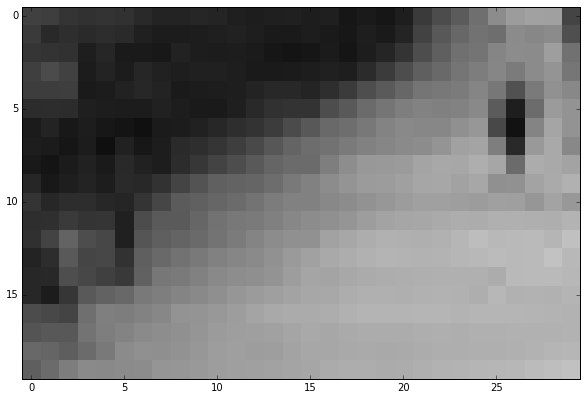

In [7]:
# plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
# Or run the original image
plt.imshow(input_image1)

#### The first layer filters, `encode1`

There are 2400 filters, each of which has dimension 2400x1800x1. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

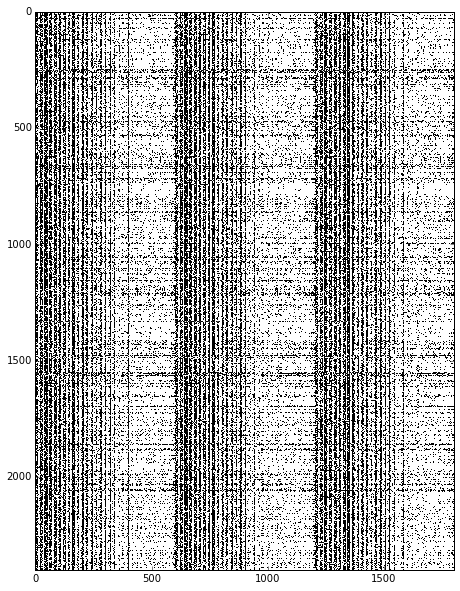

In [8]:
# the parameters are a list of [weights, biases]
filters = net.params['encode1'][0].data
vis_square(filters[:48].reshape(1**2, 2400, 1800))

The first layer output, `encode1` (rectified responses of the filters above, first 36 of 2400 channels only)

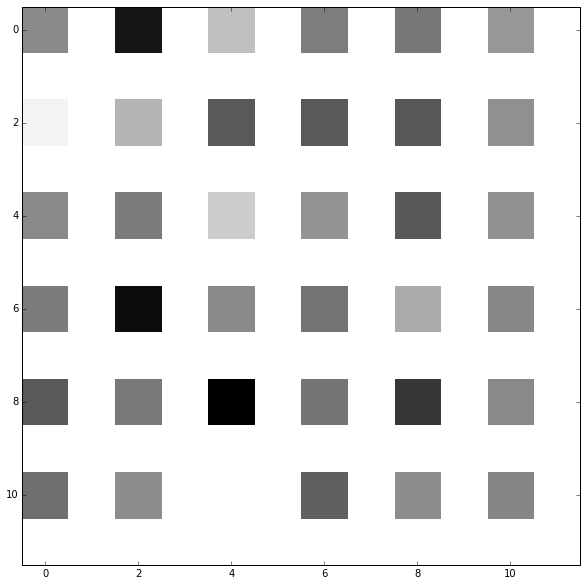

In [9]:
feat = net.blobs['encode1'].data[0,:36]
vis_square(feat, padval=1)

#### The second layer filters, `encode2`

There are 1200 filters, each of which has dimension 1200x2400x1. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

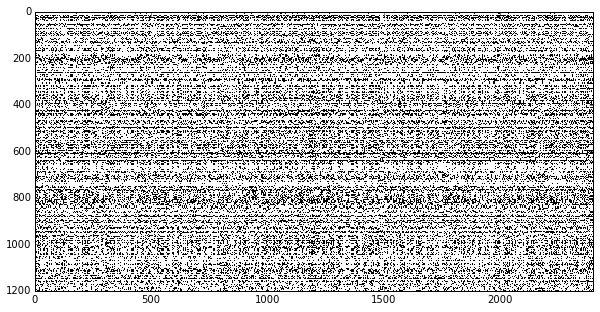

In [10]:
filters = net.params['encode2'][0].data
vis_square(filters[:48].reshape(1**2, 1200, 2400))

The second layer output, `encode2` (rectified, only the first 36 of 1200 channels)

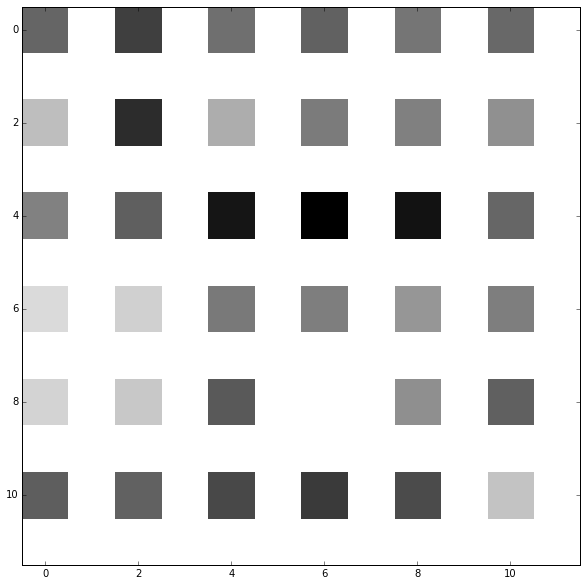

In [11]:
feat = net.blobs['encode2'].data[0,:36]
vis_square(feat, padval=1)

#### The third layer output, `encode3` (rectified, all 600 channels)

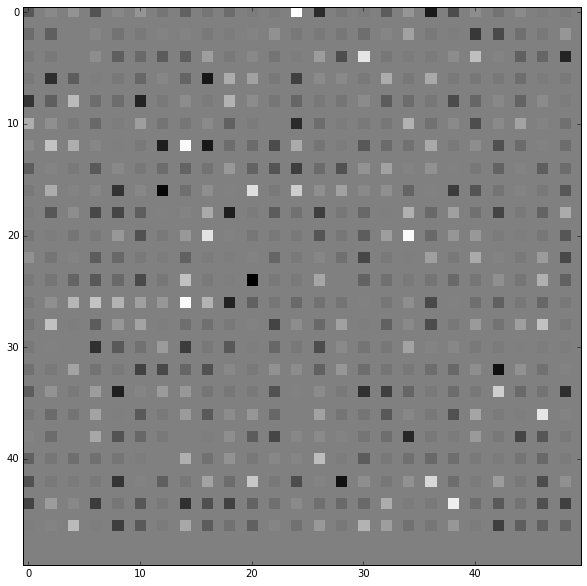

In [12]:
feat = net.blobs['encode3'].data[0]
vis_square(feat, padval=0.5)

#### The fourth layer output, `encode4` (rectified, all 72 channels)

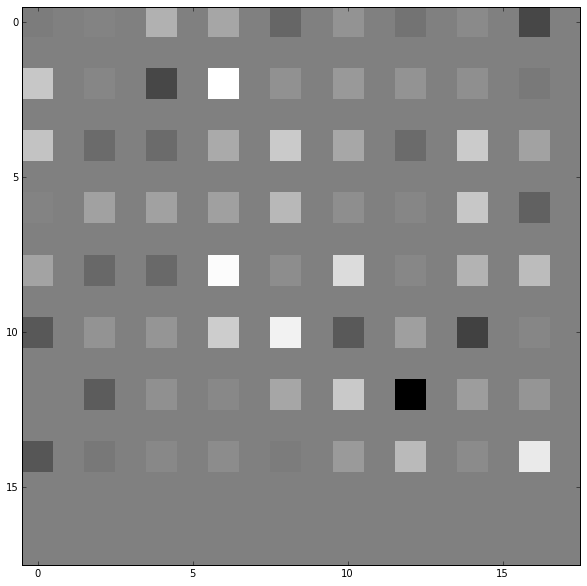

In [13]:
feat = net.blobs['encode4'].data[0]
vis_square(feat, padval=0.5)

#### The fifth layer output, `decode4` (rectified, all 600 channels)

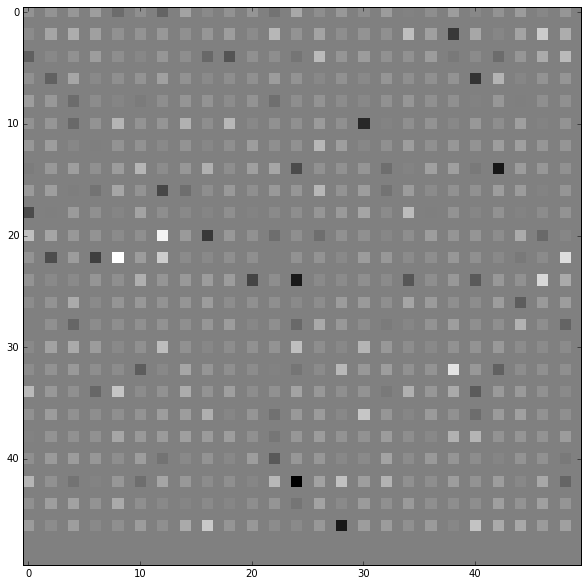

In [14]:
feat = net.blobs['decode4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after applying sigmoid function, `decode4neuron`

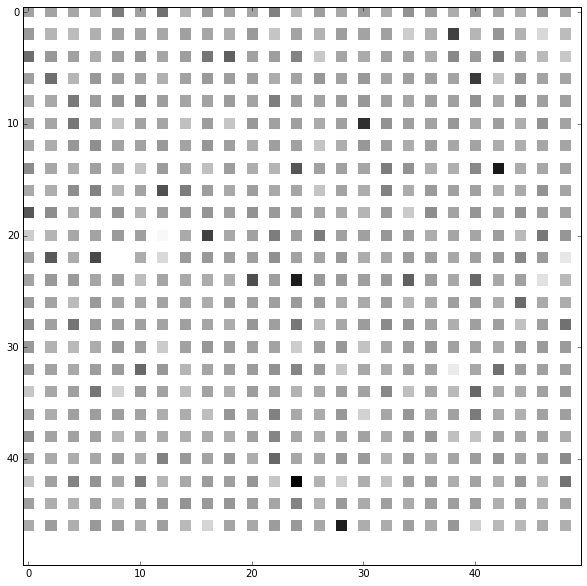

In [15]:
feat = net.blobs['decode4neuron'].data[0]
vis_square(feat, padval=1)

#### The last (eighth) layer output, `decode1` (rectified)

We show the output values and the histogram of the positive values.

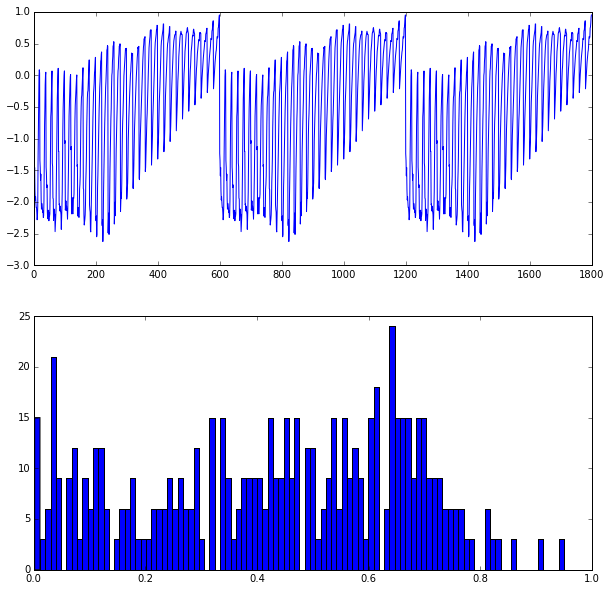

In [16]:
feat = net.blobs['decode1'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

#### The final cross entropy loss output, `cross_entropy_loss`

In [17]:
net.blobs['cross_entropy_loss'].data[0]

array([[[ 1240.35205078]]], dtype=float32)

#### The final L2 error output, `l2_error`

In [18]:
net.blobs['l2_error'].data[0]

array([[[ 42.07661819]]], dtype=float32)